In [2]:
%load_ext autoreload
%autoreload 2
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.array as da
from dask import dataframe as dd
import dask
from scipy import stats
from matplotlib.gridspec import GridSpec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
#read the df created in calculate_IPAS_area_ratio.ipynb 
df_IPAS = pd.read_hdf('df_IPAS_rand_area_ratio_no_points.h5')

In [41]:
len(df_IPAS)

3820668

In [34]:
#read in aggregate-aggregate collection data
f = open('../instance_files/instance_db_aggagg_rand', 'rb')
results = pickle.load(f)
agg_as_aggagg_rand, agg_bs_aggagg_rand, agg_cs_aggagg_rand, phi2Ds_aggagg_rand, cplxs_aggagg_rand, dds_aggagg_rand= \
                results['agg_as'], results['agg_bs'], results['agg_cs'], results['phi2Ds'], results['cplxs'], results['dds']

f.close()

In [187]:
#truncate df for monomer aspect ratio and number 
#<=50 based on column CPI dataset (50 was max aspect ratio)
upper_bound=70.0
trunc_IPAS3d = df_IPAS[(df_IPAS['mono_phi'] <= upper_bound)] #saving a copy of 3d aspect ratios to plot
truncall = df_IPAS[(df_IPAS['mono_phi'] <= upper_bound)]
trunc20 = df_IPAS[(df_IPAS['mono_phi'] <= upper_bound) & (df_IPAS['ncrystals'] <= 20)]
trunc10 = df_IPAS[(df_IPAS['mono_phi'] <= upper_bound) & (df_IPAS['ncrystals'] <= 10)]
trunc5 = df_IPAS[(df_IPAS['mono_phi'] <= upper_bound) & (df_IPAS['ncrystals'] <= 5)]
trunc2 = df_IPAS[(df_IPAS['mono_phi'] <= upper_bound) & (df_IPAS['ncrystals'] <= 2)]

lower_bound = 0.01
upper_bound = 10.0
trunc_outer = df_IPAS[(df_IPAS['mono_phi'] <= upper_bound) & (df_IPAS['mono_phi'] >= lower_bound)]

lower_bound = 0.5
upper_bound = 2.0
trunc_inner = df_IPAS[(df_IPAS['mono_phi'] <= upper_bound) & (df_IPAS['mono_phi'] >= lower_bound)]


In [136]:
len(df_CPI),len(df_nonan),len(truncall), len(trunc_outer), len(trunc_inner)

(122033, 107663, 3681556, 3010409, 436612)

In [171]:
len(df_CPI),len(df_nonan),len(truncall), len(trunc_outer), len(trunc_inner)

(110920, 107570, 3681556, 3010409, 436612)

In [8]:
#read in CPI data 
#all campaings in one file
df_CPI = pd.read_csv('df_IPAS_ellipse_aggs_allcampaigns.csv')
#only use aggregates
df_CPI = df_CPI[(df_CPI['classification'] == 'agg') & (df_CPI['cutoff'] < 5)]

In [189]:
#gather columns that are the same as IPAS dataframe to merge
df_CPI.rename(columns={'IPAS_ellipse':'Aspect Ratio' ,"filled_circular_area_ratio": "Area Ratio", 'complexity':'Complexity'}, inplace=True)
CPI =  df_CPI[['Complexity', 'Aspect Ratio', 'Area Ratio']]

truncall.rename(columns={"area_ratio": "Area Ratio", 'cplx':'Complexity', 'phi2D': 'Aspect Ratio'}, inplace=True)
trunc_all =  truncall[['Complexity', 'Aspect Ratio', 'Area Ratio']]
trunc_outer.rename(columns={"area_ratio": "Area Ratio", 'cplx':'Complexity', 'phi2D': 'Aspect Ratio'}, inplace=True)
trunc_outer =  trunc_outer[['Complexity', 'Aspect Ratio', 'Area Ratio']]
trunc_inner.rename(columns={"area_ratio": "Area Ratio", 'cplx':'Complexity', 'phi2D': 'Aspect Ratio'}, inplace=True)
trunc_inner =  trunc_inner[['Complexity', 'Aspect Ratio', 'Area Ratio']]


/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [265]:
df_cplx = pd.concat([truncall['Complexity'], trunc_outer['Complexity'], trunc_inner['Complexity'], CPI['Complexity']], keys=['$\phi_m$=0.01-70.0', '$\phi_m$=0.1-10.0', '$\phi_m$=0.5-2.0', 'CPI'], names=["Source"]).reset_index().drop(columns='level_1')
df_phi = pd.concat([truncall['Aspect Ratio'], trunc_outer['Aspect Ratio'], trunc_inner['Aspect Ratio'], CPI['Aspect Ratio']], keys=['$\phi_m$=0.01-70.0', '$\phi_m$=0.1-10.0', '$\phi_m$=0.5-2.0', 'CPI'], names=["Source"]).reset_index().drop(columns='level_1')
df_ar = pd.concat([truncall['Area Ratio'], trunc_outer['Area Ratio'], trunc_inner['Area Ratio'], CPI['Area Ratio']], keys=['$\phi_m$=0.01-70.0', '$\phi_m$=0.1-10.0', '$\phi_m$=0.5-2.0', 'CPI'], names=["Source"]).reset_index().drop(columns='level_1')

In [255]:
#combine CPI and IPAS data to plot
#aspect ratio only for cutoff > 5%, otherwise NaN
cdf_all = pd.concat([truncall, trunc_outer, trunc_inner, CPI], keys=['$\phi_m$=0.01-70.0', '$\phi_m$=0.1-10.0', '$\phi_m$=0.5-2.0', 'CPI'], names=["Source"]).reset_index().drop(columns='level_1')

# cdf_outer = pd.concat([CPI, trunc_outer], keys=['CPI', 'IPAS'], names=["Source"]).reset_index().drop(columns='level_1')

# cdf_inner = pd.concat([CPI, trunc_inner], keys=['CPI', 'IPAS'], names=["Source"]).reset_index().drop(columns='level_1')

In [191]:
#for plotting. need a source column for hue argument in seaborn
cdf_all = pd.melt(cdf_all,id_vars=['Source'],value_vars=['Complexity', 'Aspect Ratio', 'Area Ratio'],
             value_name='Magnitude')
# cdf_outer = pd.melt(cdf_outer,id_vars=['Source'],value_vars=['Complexity', 'Aspect Ratio', 'Area Ratio'],
#              value_name='Value')
# cdf_inner = pd.melt(cdf_inner,id_vars=['Source'],value_vars=['Complexity', 'Aspect Ratio', 'Area Ratio'],
#              value_name='Value')

In [183]:
cdf_all[cdf_all['variable']=='Complexity']

,Source,variable,Magnitude
0,IPAS $\phi_m$=0.01-70.0,Complexity,0.284048
1,IPAS $\phi_m$=0.01-70.0,Complexity,0.466069
2,IPAS $\phi_m$=0.01-70.0,Complexity,0.500040
3,IPAS $\phi_m$=0.01-70.0,Complexity,0.845821
4,IPAS $\phi_m$=0.01-70.0,Complexity,0.570485
...,...,...,...
7239492,CPI,Complexity,0.537231
7239493,CPI,Complexity,0.781351
7239494,CPI,Complexity,0.924269
7239495,CPI,Complexity,0.780049


In [192]:
df_nonan = df_CPI[df_CPI['Aspect Ratio'].notnull()]

In [ ]:
#bins, edges = np.histogram(np.isfinite(truncall['phi2D']), density=True, bins = 70)
n, bins, patchs = plt.hist(truncall['phi2D'][np.isfinite(truncall['phi2D'])], density=True, bins = 70);

In [ ]:
n, bins, patchs = plt.hist(truncall['area ratio'][np.isfinite(truncall['area ratio'])], density=True, bins = 70);

In [ ]:
n, bins, patchs = plt.hist(CPI['Area Ratio'], density=True, bins = 70);
plt.axvline(x=0.44, color='magenta', label='RMSE 1')

In [ ]:
len(cplxs_aggagg_rand[:,:,:].flatten())

In [282]:
xlarge=24; large = 20; med = 16; small = 12
params = {'axes.titlesize': xlarge,
          'legend.fontsize': med,
          'axes.labelsize': xlarge,
          'xtick.labelsize': large,
          'ytick.labelsize': large,
          'figure.titlesize': large,
          "font.family": "serif"}
import matplotlib as mpl  
mpl.rc('font',family='serif')
plt.rcParams.update(params)

In [ ]:
stats.mode(df_nonan['IPAS_ellipse'])

In [ ]:
stats.mode(trunc5['cplx'])

/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed i

Text(0.5, 0, 'Bulk Statistics')

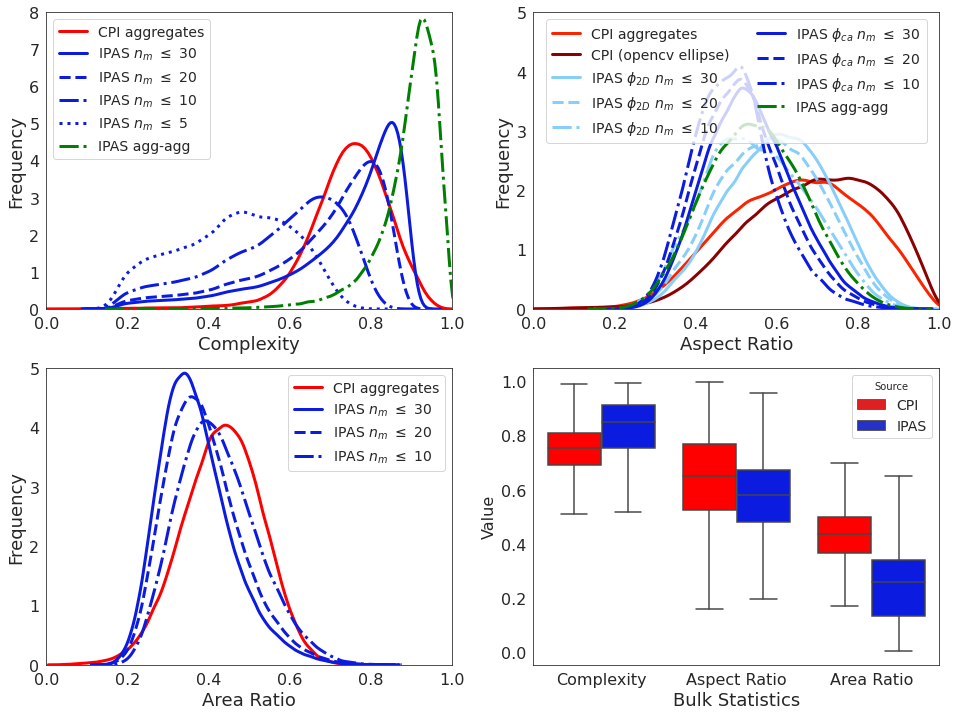

In [46]:
#fig, ax = plt.subplots()
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))
sns.set_style("white")

g=sns.distplot(df_nonan['Aspect Ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'#FA2400'}, label='CPI aggregates',ax=ax2)

#sns.distplot(df_nonan['opencv_ellipse'], hist = False, kde = True, norm_hist=True,
#              kde_kws = {'linewidth': 3,'color':'darkred'}, label='CPI (opencv ellipse)', ax=ax2)

g=sns.distplot(truncall['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'lightskyblue'}, label='IPAS $\phi_{2D}$ $n_m$ $\leq$ 30',ax=ax2)

g=sns.distplot(trunc20['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--','color':'lightskyblue'}, label='IPAS $\phi_{2D}$ $n_m$ $\leq$ 20',ax=ax2)

g=sns.distplot(trunc10['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.','color':'lightskyblue'}, label='IPAS $\phi_{2D}$ $n_m$ $\leq$ 10',ax=ax2)

#g=sns.distplot(trunc5['phi2D'], hist = False, kde = True, norm_hist=True,
#             kde_kws = {'linewidth': 3, 'linestyle':':','color':'lightskyblue'}, label='IPAS $\phi_{2D}$ $n_m$ < 5',ax=ax2)

g=sns.distplot(truncall['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'#0B1CE0'}, label='IPAS $\phi_{ca}$ $n_m$ $\leq$ 30',ax=ax2)

g=sns.distplot(trunc20['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--','color':'#0B1CE0'}, label='IPAS $\phi_{ca}$ $n_m$ $\leq$ 20',ax=ax2)

g=sns.distplot(trunc10['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.','color':'#0B1CE0'}, label='IPAS $\phi_{ca}$ $n_m$ $\leq$ 10',ax=ax2)

#g=sns.distplot(trunc5['agg_phi'], hist = False, kde = True, norm_hist=True,
#             kde_kws = {'linewidth': 3, 'linestyle':':','color':'#0B1CE0'}, label='IPAS $\phi_{ca}$ $n_m$ < 5',ax=ax2)
#g=sns.distplot(phi2Ds_aggagg_rand[1:11,:,:], hist = False, kde = True, norm_hist=True,
#             kde_kws = {'linewidth': 3, 'linestyle':'-.','color':'green'}, label='IPAS agg-agg',ax=ax2)


ax2.set_xlabel("Aspect Ratio",fontsize=18)
ax2.set_ylabel("Frequency",fontsize=18)
ax2.set_ylim(0, 5)
ax2.set_xlim(0.0, 1.0)
ax2.legend(loc='upper center', ncol=2)

sns.distplot(df_CPI['Complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI aggregates', ax=ax1)
sns.distplot(truncall['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'#0B1CE0'}, label='IPAS $n_m$ $\leq$ 30', ax=ax1)
sns.distplot(trunc20['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--', 'color':'#0B1CE0'}, label='IPAS $n_m$ $\leq$ 20', ax=ax1)
sns.distplot(trunc10['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.', 'color':'#0B1CE0'}, label='IPAS $n_m$ $\leq$ 10', ax=ax1)
sns.distplot(trunc5['cplx'], hist = False, kde = True, norm_hist=True,
            kde_kws = {'linewidth': 3, 'linestyle':':', 'color':'#0B1CE0'}, label='IPAS $n_m$ $\leq$ 5', ax=ax1)
#sns.distplot(cplxs_aggagg_rand[:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
#              kde_kws = {'linewidth': 3, 'linestyle':'-.','color':'green'}, label='IPAS agg-agg', ax=ax1)

ax1.set_xlabel("Complexity",fontsize=18)
ax1.set_ylabel("Frequency",fontsize=18)
ax1.set_xlim(0.0, 1.0)
ax1.set_ylim(0, 8)
ax1.legend()

sns.distplot(df_CPI['Area Ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI aggregates', ax=ax3)
sns.distplot(truncall['area_ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'#0B1CE0'}, label='IPAS $n_m$ $\leq$ 30', ax=ax3)
sns.distplot(trunc20['area_ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--', 'color':'#0B1CE0'}, label='IPAS $n_m$ $\leq$ 20', ax=ax3)
sns.distplot(trunc10['area_ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.', 'color':'#0B1CE0'}, label='IPAS $n_m$ $\leq$ 10', ax=ax3)

ax3.set_xlabel("Area Ratio",fontsize=18)
ax3.set_ylabel("Frequency",fontsize=18)
ax3.set_xlim(0.0, 1.0)
ax3.set_ylim(0, 5)
ax3.legend()

ax4 = sns.boxplot(x="variable", y="Value", hue="Source", data=cdf, palette={'CPI': 'red', 'IPAS':'#0B1CE0'}, showfliers=False, ax=ax4)

for i in range(0,6,2):
    cpi_color = ax4.artists[i]
    cpi_color.set_facecolor('red')
for i in range(1,6,2):
    ipas_color = ax4.artists[i]
    ipas_color.set_facecolor('#0B1CE0')
ax4.set_xlabel("Bulk Statistics",fontsize=18)
#ax4.legend()

#plt.savefig('../plots/CPI_IPAS_distributions.png', dpi=300, bbox_inches='tight')

/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed i

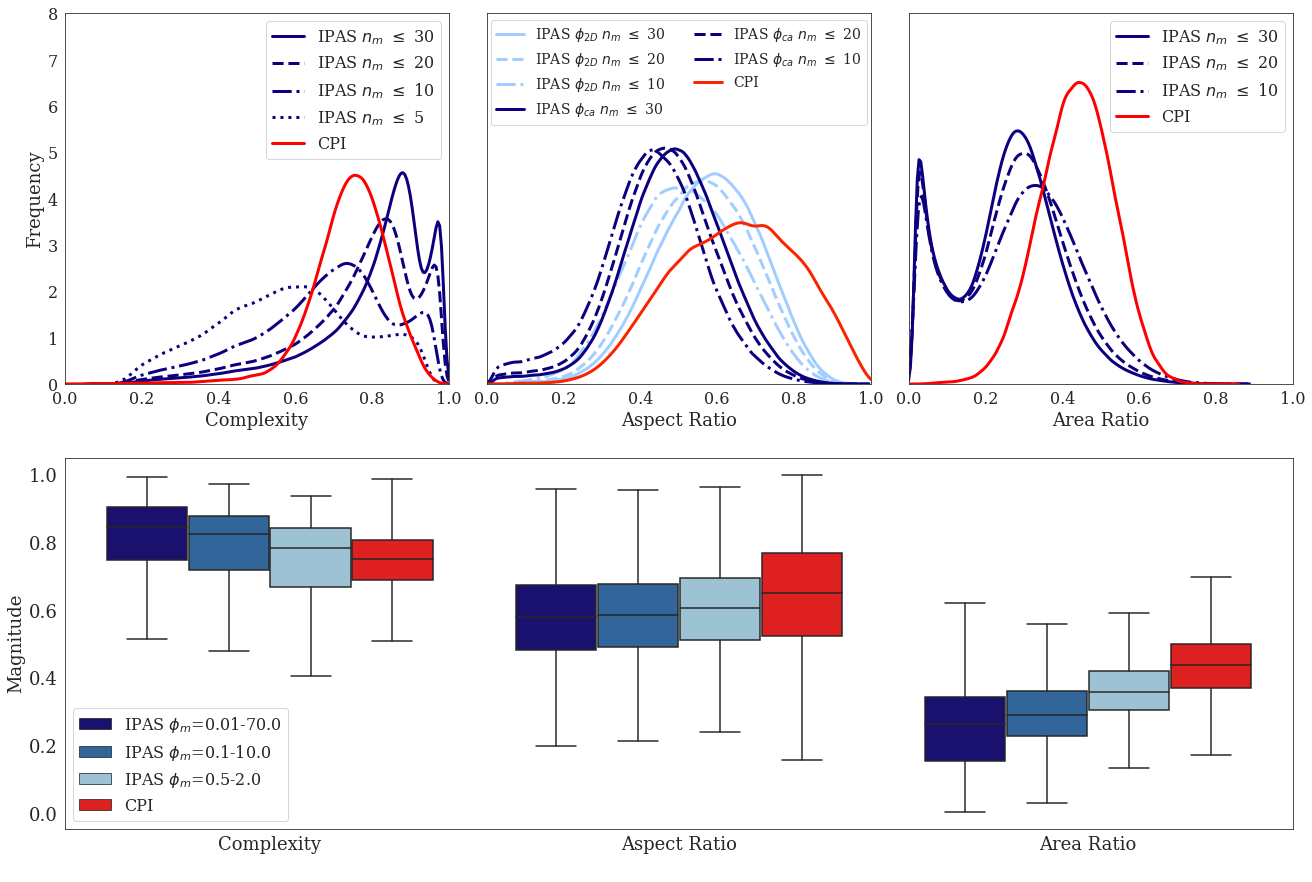

In [180]:
# Setting up the plot surface
fig = plt.figure(figsize=(22, 15))
gs = GridSpec(nrows=2, ncols=3, wspace=0.1)

# First axes
ax1 = fig.add_subplot(gs[0, 0])
sns.distplot(truncall['Complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 30', ax=ax1)
sns.distplot(trunc20['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--', 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 20', ax=ax1)
sns.distplot(trunc10['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.', 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 10', ax=ax1)
sns.distplot(trunc5['cplx'], hist = False, kde = True, norm_hist=True,
            kde_kws = {'linewidth': 3, 'linestyle':':', 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 5', ax=ax1)
#sns.distplot(cplxs_aggagg_rand[:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
#              kde_kws = {'linewidth': 3, 'linestyle':'-.','color':'green'}, label='IPAS agg-agg', ax=ax1)
sns.distplot(df_CPI['Complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI', ax=ax1)

ax1.set_xlabel("Complexity",fontsize=18)
ax1.set_ylabel("Frequency",fontsize=18)
ax1.set_xlim(0.0, 1.0)
ax1.set_ylim(0, 8)
ax1.legend()

# Second axes
ax2 = fig.add_subplot(gs[0, 1])

#sns.distplot(df_nonan['opencv_ellipse'], hist = False, kde = True, norm_hist=True,
#              kde_kws = {'linewidth': 3,'color':'darkred'}, label='CPI (opencv ellipse)', ax=ax2)

g=sns.distplot(truncall['Aspect Ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'#a1ceff'}, label='IPAS $\phi_{2D}$ $n_m$ $\leq$ 30',ax=ax2)

g=sns.distplot(trunc20['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--','color':'#a1ceff'}, label='IPAS $\phi_{2D}$ $n_m$ $\leq$ 20',ax=ax2)

g=sns.distplot(trunc10['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.','color':'#a1ceff'}, label='IPAS $\phi_{2D}$ $n_m$ $\leq$ 10',ax=ax2)

#g=sns.distplot(trunc5['phi2D'], hist = False, kde = True, norm_hist=True,
#             kde_kws = {'linewidth': 3, 'linestyle':':','color':'lightskyblue'}, label='IPAS $\phi_{2D}$ $n_m$ < 5',ax=ax2)

g=sns.distplot(trunc_IPAS3d['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'#0D007E'}, label='IPAS $\phi_{ca}$ $n_m$ $\leq$ 30',ax=ax2)

g=sns.distplot(trunc20['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--','color':'#0D007E'}, label='IPAS $\phi_{ca}$ $n_m$ $\leq$ 20',ax=ax2)

g=sns.distplot(trunc10['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.','color':'#0D007E'}, label='IPAS $\phi_{ca}$ $n_m$ $\leq$ 10',ax=ax2)
g=sns.distplot(df_nonan['Aspect Ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'#FA2400'}, label='CPI',ax=ax2)

ax2.set_xlabel("Aspect Ratio",fontsize=18)
ax2.axes.get_yaxis().set_visible(False)
ax2.yaxis.set_label_text(' ')
ax2.set_ylim(0, 5)
ax2.set_xlim(0.0, 1.0)
ax2.legend(loc='upper center', ncol=2, fontsize=14)

ax3 = fig.add_subplot(gs[0, 2])
sns.distplot(truncall['Area Ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 30', ax=ax3)
sns.distplot(trunc20['area_ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--', 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 20', ax=ax3)
sns.distplot(trunc10['area_ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.', 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 10', ax=ax3)
sns.distplot(df_CPI['Area Ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI', ax=ax3)

ax3.set_xlabel("Area Ratio",fontsize=18)
ax3.axes.get_yaxis().set_visible(False)
ax3.yaxis.set_label_text(' ')
ax3.set_xlim(0.0, 1.0)
ax3.set_ylim(0, 5)
ax3.legend()

#cdf1=0.01-100.0
#cdf2=0.1-10.0
#cdf3=0.5-2.0

ax4 = fig.add_subplot(gs[1, :])
ax4 = sns.boxplot(x="variable", y="Magnitude", hue="Source", data=cdf_all,\
                  palette={'CPI': 'red',\
                         'IPAS $\phi_m$=0.01-70.0':'#0D007E', \
                         'IPAS $\phi_m$=0.1-10.0':'#2166AC',\
                         'IPAS $\phi_m$=0.5-2.0':'#92C5DE'}, showfliers=False, ax=ax4)
ax4.set_xlabel(" ")
plt.ylabel("Magnitude", size=18)
#ax4.set_ylabel("Magnitude", labelsize=18)
ax4.tick_params(axis='both', which='major', labelsize=18)
ax4.legend().texts[0].set_text("IPAS $\phi_m$=0.01-70.0")

#handles, labels = ax4.get_legend_handles_labels()
#ax4.legend(handles=handles[1:], labels=labels[])

plt.savefig('../plots/CPI_IPAS_distributions.png', dpi=300, bbox_inches='tight')

/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed i

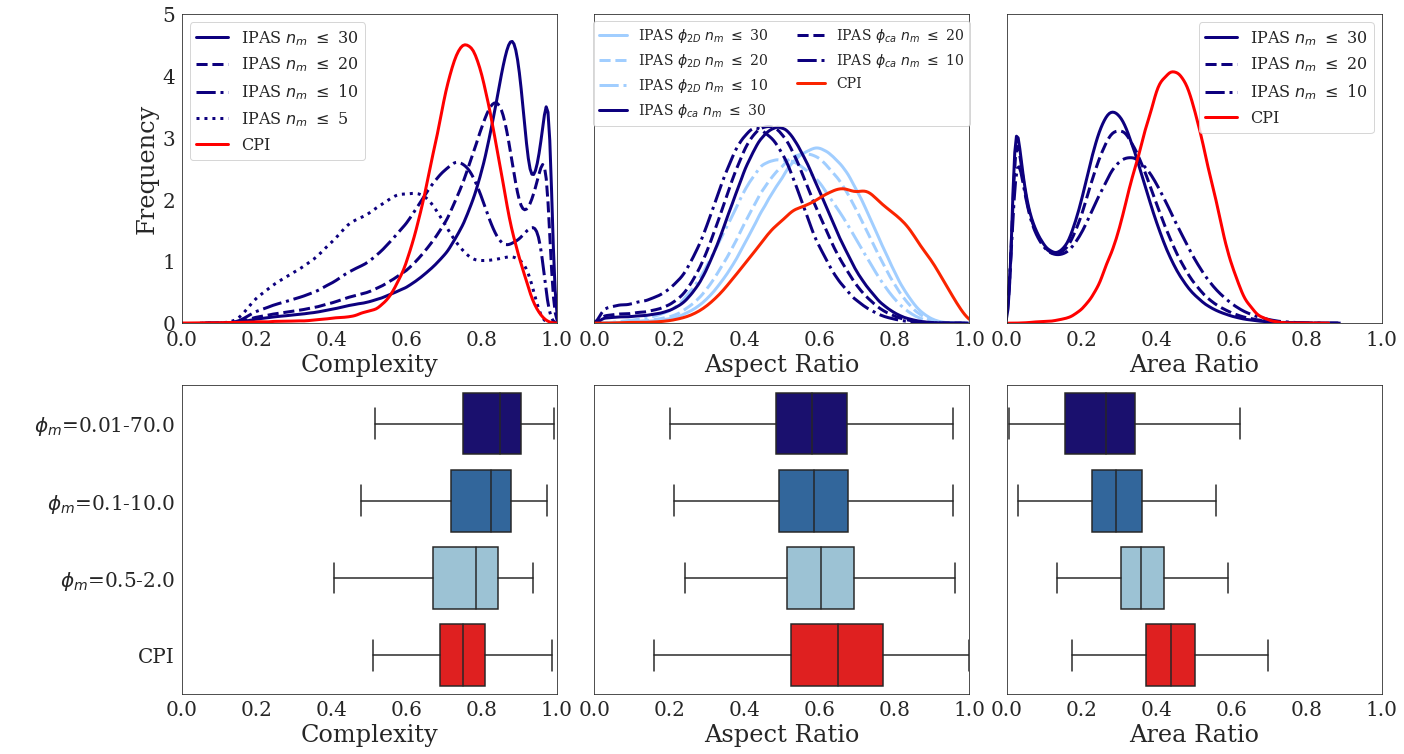

In [283]:
# Setting up the plot surface
fig = plt.figure(figsize=(21.5, 12.5))
gs = GridSpec(nrows=2, ncols=3, wspace=0.1)

#First axes
ax1 = fig.add_subplot(gs[0, 0])
sns.distplot(truncall['Complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 30', ax=ax1)
sns.distplot(trunc20['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--', 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 20', ax=ax1)
sns.distplot(trunc10['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.', 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 10', ax=ax1)
sns.distplot(trunc5['cplx'], hist = False, kde = True, norm_hist=True,
            kde_kws = {'linewidth': 3, 'linestyle':':', 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 5', ax=ax1)
#sns.distplot(cplxs_aggagg_rand[:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
#              kde_kws = {'linewidth': 3, 'linestyle':'-.','color':'green'}, label='IPAS agg-agg', ax=ax1)
sns.distplot(df_CPI['Complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI', ax=ax1)

ax1.set_xlabel("Complexity")
ax1.set_ylabel("Frequency")
ax1.set_ylim(0, 5)
ax1.legend(loc='upper left', ncol=1)

# Second axes
ax2 = fig.add_subplot(gs[0, 1])

#sns.distplot(df_nonan['opencv_ellipse'], hist = False, kde = True, norm_hist=True,
#              kde_kws = {'linewidth': 3,'color':'darkred'}, label='CPI (opencv ellipse)', ax=ax2)

g=sns.distplot(truncall['Aspect Ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'#a1ceff'}, label='IPAS $\phi_{2D}$ $n_m$ $\leq$ 30',ax=ax2)

g=sns.distplot(trunc20['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--','color':'#a1ceff'}, label='IPAS $\phi_{2D}$ $n_m$ $\leq$ 20',ax=ax2)

g=sns.distplot(trunc10['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.','color':'#a1ceff'}, label='IPAS $\phi_{2D}$ $n_m$ $\leq$ 10',ax=ax2)

#g=sns.distplot(trunc5['phi2D'], hist = False, kde = True, norm_hist=True,
#             kde_kws = {'linewidth': 3, 'linestyle':':','color':'lightskyblue'}, label='IPAS $\phi_{2D}$ $n_m$ < 5',ax=ax2)

g=sns.distplot(trunc_IPAS3d['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'#0D007E'}, label='IPAS $\phi_{ca}$ $n_m$ $\leq$ 30',ax=ax2)

g=sns.distplot(trunc20['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--','color':'#0D007E'}, label='IPAS $\phi_{ca}$ $n_m$ $\leq$ 20',ax=ax2)

g=sns.distplot(trunc10['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.','color':'#0D007E'}, label='IPAS $\phi_{ca}$ $n_m$ $\leq$ 10',ax=ax2)

g=sns.distplot(df_nonan['Aspect Ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'#FA2400'}, label='CPI',ax=ax2)

ax2.set_xlabel("Aspect Ratio")
ax2.axes.get_yaxis().set_visible(False)
ax2.yaxis.set_label_text(' ')
ax2.set_ylim(0, 5)
ax2.legend(loc='upper center', ncol=2, fontsize=14)

ax3 = fig.add_subplot(gs[0, 2])
sns.distplot(truncall['Area Ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 30', ax=ax3)
sns.distplot(trunc20['area_ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--', 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 20', ax=ax3)
sns.distplot(trunc10['area_ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'-.', 'color':'#0D007E'}, label='IPAS $n_m$ $\leq$ 10', ax=ax3)
sns.distplot(df_CPI['Area Ratio'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI', ax=ax3)

ax3.set_xlabel("Area Ratio")
ax3.axes.get_yaxis().set_visible(False)
ax3.yaxis.set_label_text(' ')
ax3.set_ylim(0, 5)
ax3.legend()

ax4 = fig.add_subplot(gs[1, 0])
ax4 = sns.boxplot(x="Complexity", y="Source", data=df_cplx,\
                  palette={'CPI': 'red',\
                         '$\phi_m$=0.01-70.0':'#0D007E', \
                         '$\phi_m$=0.1-10.0':'#2166AC',\
                         '$\phi_m$=0.5-2.0':'#92C5DE'}, showfliers=False, ax=ax4, orient='h')

ax4.set_ylabel(" ")
ax4.set_xlabel("Complexity")
ax4.set_yticklabels(ax4.get_yticklabels(), size=20)

ax5 =fig.add_subplot(gs[1, 1])
ax5 = sns.boxplot(x="Aspect Ratio", y='Source', data=df_phi,\
                  palette={'CPI': 'red',\
                         '$\phi_m$=0.01-70.0':'#0D007E', \
                         '$\phi_m$=0.1-10.0':'#2166AC',\
                         '$\phi_m$=0.5-2.0':'#92C5DE'}, showfliers=False, ax=ax5, orient='h')

ax5.axes.get_yaxis().set_visible(False)
ax5.set_xlabel("Aspect Ratio")

ax6 =fig.add_subplot(gs[1, 2])
ax6 = sns.boxplot(x="Area Ratio", y="Source", data=df_ar,\
                  palette={'CPI': 'red',\
                         '$\phi_m$=0.01-70.0':'#0D007E', \
                         '$\phi_m$=0.1-10.0':'#2166AC',\
                         '$\phi_m$=0.5-2.0':'#92C5DE'}, showfliers=False, ax=ax6, orient='h')

ax6.axes.get_yaxis().set_visible(False)
ax6.set_xlabel("Area Ratio")

for ax in plt.gcf().axes:
    ax.set_xlim(0.0, 1.0)


plt.savefig('../plots/CPI_IPAS_distributions.png', dpi=300, bbox_inches='tight')

In [285]:
np.std(df_nonan['Aspect Ratio']), np.std(truncall['Aspect Ratio'])

(0.16255895347247204, 0.13453635885335746)

In [ ]:
bins, edges = np.histogram(trunc5['cplx'], density=True, bins=70)
edges[np.where(bins == np.max(bins))]

CPI aggregates a little less complex 

CPI data looks more quasi-spherical in terms of aspect ratios: add in other particle types, not just aggs

# All CPI particle types

In [ ]:
#read in CPI data 
#all campaings in one file
df_CPI = pd.read_csv('final_databases/no_mask/all_campaigns.csv')
df_CPI = df_CPI[df_CPI['classification'] != 'blank']

In [ ]:
len(df_CPI), len(ddf), len(phi2D.flatten())

In [ ]:
#phi2D and phi2Ds from 0.25-10.0, 30 monomers, r_m = 10
#agg_phi, 3D from database from 0.25-10.0, 30 monomers, all r_m
fig, ax = plt.subplots(figsize=(7,5))

sns.distplot(phi2D[1:-1,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS 2D')
sns.distplot(phi2Ds[1:-1,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--', 'color': 'lightblue'}, label='IPAS mean 2D')
sns.distplot(ddf['agg_phi'][(ddf['mono_phi'] <= 10.0) & (ddf['mono_phi'] >= 0.25)], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color': 'orange'}, label='IPAS 3D')
sns.distplot(df_CPI['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Aspect Ratio', ylabel='Frequency');

In [ ]:
n, bins, patches = plt.hist(df_CPI['complexity'], bins = 40)
bins[np.where(n == n.max())]  #max CPI aspect ratio from ellipse (not averaged)

In [ ]:
#mode of complexity histogram only dropped by 0.035 including all particle types

In [ ]:
#play around with specific particle types
df_CPI['classification'].unique()

In [ ]:
df_CPI = pd.read_csv('final_databases/no_mask/all_campaigns.csv')
df_CPI = df_CPI[(df_CPI['classification'] == 'agg') | \
               (df_CPI['classification'] == 'rimed agg') | \
               (df_CPI['classification'] == 'bullet') | \
               (df_CPI['classification'] == 'compact irregular')]

In [ ]:
#phi2D and phi2Ds from 0.25-10.0, 30 monomers, r_m = 10
#agg_phi, 3D from database from 0.25-10.0, 30 monomers, all r_m
fig, ax = plt.subplots(figsize=(7,5))

sns.distplot(phi2D[:,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS 2D')
sns.distplot(phi2Ds[:,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--', 'color': 'lightblue'}, label='IPAS mean 2D')
sns.distplot(ddf['agg_phi'][(ddf['mono_phi'] <= 10.0) & (ddf['mono_phi'] >= 0.25)], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color': 'orange'}, label='IPAS 3D')
sns.distplot(df_CPI['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Aspect Ratio', ylabel='Frequency');

In [ ]:
df_CPI = pd.read_csv('final_databases/no_mask/all_campaigns.csv')

In [ ]:
df_CPI_bullet = df_CPI[(df_CPI['classification'] == 'bullet')]

In [ ]:
df_CPI_plate = df_CPI[(df_CPI['classification'] == 'plate')]

In [ ]:
df_CPI_agg = df_CPI[(df_CPI['classification'] == 'agg')]

In [ ]:
df_CPI_rimed_agg = df_CPI[(df_CPI['classification'] == 'rimed agg')]

In [ ]:
df_CPI_compact = df_CPI[(df_CPI['classification'] == 'compact irregular')]

In [ ]:
df_CPI_rimed_col = df_CPI[(df_CPI['classification'] == 'rimed column')]

In [10]:
df_CPI_column = df_CPI[(df_CPI['classification'] == 'column') | (df_CPI['classification'] == 'needle')]

In [11]:
df_CPI_column

,campaign,filename,height,width,lapl,contours,edges,std,cnt_area,contrast,...,column,compact irregular,fragment,needle,plate,rimed agg,rimed column,sphere,classification,IPAS_ellipse


In [ ]:
#phi2D and phi2Ds from 0.25-10.0, 30 monomers, r_m = 10
#agg_phi, 3D from database from 0.25-10.0, 30 monomers, all r_m
fig, ax = plt.subplots(figsize=(7,5))

sns.distplot(phi2D[1:-1,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS 2D')
sns.distplot(phi2Ds[1:-1,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--', 'color': 'lightblue'}, label='IPAS mean 2D')
sns.distplot(ddf['agg_phi'][(ddf['mono_phi'] <= 10.0) & (ddf['mono_phi'] >= 0.25)], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color': 'orange'}, label='IPAS 3D')
sns.distplot(df_CPI_rimed_agg['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Aspect Ratio', ylabel='Frequency');

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
sns.distplot(trunc['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS')
sns.distplot(df_CPI_rimed_col['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Complexity', ylabel='Frequency');

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
sns.distplot(trunc['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS')
sns.distplot(df_CPI_column['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Complexity', ylabel='Frequency');

In [ ]:
#truncate # of monomers
trunc = ddf[(ddf['mono_phi'] > 0.01) & (ddf['mono_phi'] < 50) & (ddf['ncrystals'] < 20)]

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_CPI_agg['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='aggregate')

sns.distplot(df_CPI_bullet['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='bullet rosette')

sns.distplot(df_CPI_compact['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='compact irregular')

sns.distplot(df_CPI_column['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='column')

sns.distplot(df_CPI_plate['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='plate')

sns.distplot(df_CPI_rimed_agg['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='rimed agg')

sns.distplot(df_CPI_rimed_col['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='rimed column')

sns.distplot(trunc['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--'}, label='IPAS $n_m$ < 20')


ax.set(xlabel='Complexity', ylabel='Frequency');

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_CPI_agg['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'red'}, label='aggregate')

sns.distplot(phi2Ds[1:-1,:,:20].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--','color':'blue'}, label='IPAS avg 2D $n_m$ < 20')

sns.distplot(phi2Ds[1:-1,:,:10].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'blue'}, label='IPAS avg 2D $n_m$ < 10')

sns.distplot(phi2D[1:-1,:,:20].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--','color':'lightblue'}, label='IPAS 2D $n_m$ < 20')

sns.distplot(trunc['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'lightblue'}, label='IPAS db 2D $n_m$ < 20')
#phi_m 0.01 and 50^
sns.distplot(trunc['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--','color':'orange'}, label='IPAS db 3D $n_m$ < 20')
#phi_m 0.01 and 50^
sns.distplot(ddf['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'orange'}, label='IPAS db 3D $n_m$ < 30')


ax.set(xlabel='Aspect Ratio', ylabel='Frequency');

In [ ]:
trunc = ddf[(ddf['mono_phi'] > 0.01) & (ddf['mono_phi'] < 50) & (ddf['ncrystals'] < 10)]

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
#trunc = ddf[(ddf['mono_phi'] > 0.01) & (ddf['mono_phi'] < 50) & (ddf['ncrystals'] < 30)]
sns.distplot(df_CPI_bullet['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='bullet rosette')

sns.distplot(df_CPI_compact['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='compact irregular')

sns.distplot(df_CPI_column['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='column')

sns.distplot(df_CPI_plate['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='plate')

sns.distplot(df_CPI_rimed_agg['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='rimed aggregate')

sns.distplot(df_CPI_rimed_col['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='rimed column')

sns.distplot(ddf['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--'}, label='IPAS 3D $n_m$ < 20')

sns.distplot(ddf['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--'}, label='IPAS 2D $n_m$ < 20')
